In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2023-09-14 03:31:14.084650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 03:31:16.161754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-09-14 03:31:18.719198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 03:31:18.978591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 03:31:18.978915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import os
import cv2
import imghdr
import numpy as np

In [4]:
%matplotlib inline

In [5]:
data_dir = 'Dataset'

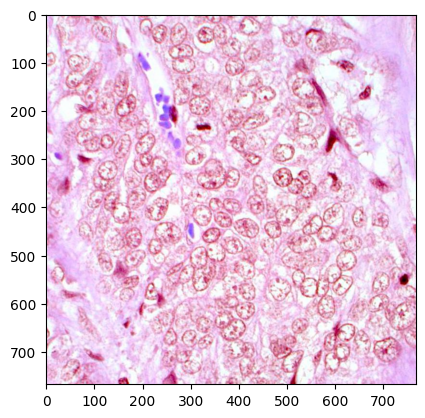

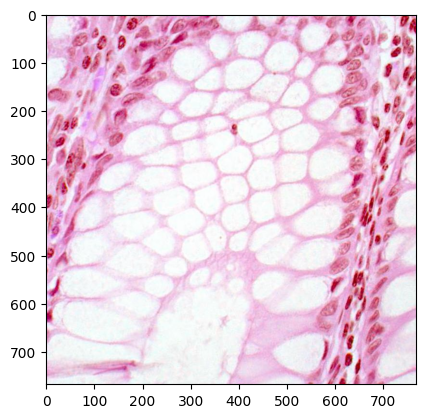

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        img = cv2.imread(image_path)
        # imghdr module determines the type of image contained in a file or byte stream
        tip = imghdr.what(image_path)
        plt.imshow(img)
        plt.show()
        break

#### Load Data

In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory('Dataset',
                                                           batch_size=5)

In [ ]:
class_labels = data.class_names
class_labels

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Data Preprocessing

In [ ]:
data = data.map(lambda x,y: (x / 255, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
batch[0].shape

### Build Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D 

### Build Generator

In [ ]:
img_rows = 256
img_cols = 256
channels = 3

img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 32
def build_generator():
    model = Sequential()
    
    # Takes in random values and reshapes it to 64x64x128
    model.add(Dense(64 * 64 * 32, input_dim=z_dim))
    model.add(LeakyReLU(0.01))
    model.add(Reshape((64, 64,32)))
    
    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(32, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(32, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(32, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convlutional block 2
    model.add(Conv2D(32, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to three channel
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
    
    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

In [ ]:
img = generator.predict(np.random.randn(4,32))

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(image))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

### Build Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(16, 5, input_shape = (256, 256, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(32, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Cov Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Cov Block
    model.add(Conv2D(32, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    
    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

In [ ]:
discriminator.predict(img)

### Construct Training Loop

#### Setup Losses and Optimizers

In [ ]:
# Adam is the optimizer for both nets
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt  = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### Buils Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
class ColonGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        
        # Create attributes for generator and discriminator
        self.generator = generator
        self.discriminator = discriminator
        
    def train_step(self, batch):
        # Get the data
        real_images = batch[0]
        fake_images = self.generator(tf.random.normal((32, 32)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape:
        # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the Tue outputs 
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((32, 32)), training=True)
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                   
            # Calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)                      
                                   
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
       
        return {"d_loss":total_d_loss, "g_loss": total_g_loss}
                                  
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def test_setp(self):
        pass

In [ ]:
tf.random.normal((128, 128, 3)).shape

In [ ]:
# Create instance of subclassed model
colongan = ColonGAN(generator, discriminator)

In [ ]:
colongan.compile(g_opt, d_opt, g_loss, d_loss)

#### Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=32):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epock, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('fake_images', f'generated_img{epoch}_{i}.png'))

### Train

In [ ]:
hist = colongan.fit(data, epochs = 20, callbacks=[ModelMonitor()])